In [1]:
import numpy as np
from scipy.sparse import vstack
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.patches as patches
import dro_model
import gurobipy as grb
%matplotlib inline
rc('font', family='serif')
rc('text', usetex=True)

In [2]:
def gen_image(images, epsilons, alphas=None, sign=None):
    fig, ax_arr = plt.subplots(epsilons.size, figsize = (7,7))
    plt.rcParams['text.latex.preamble']=[r'\usepackage{bm}']
    for index, ax in enumerate(ax_arr):
        three_d = np.reshape(1 - images[:, :, index], (-1, 28, 28)) * 255
        two_d = np.hstack([three_d[i, :, :].astype(np.uint8)
                           for i in range(three_d.shape[0])])
        if alphas is None:
            ax.set_title(r'$\rho={0:g}$'.format(epsilons[index]),
                         fontdict={'size': 16})
        else:
            alpha = np.array2string(alphas[:, index],
                                    precision=2,
                                    formatter={'float':lambda x: '%1.2g' % x},
                                    separator=', ')
            ax.set_title(
                r'$\rho={0:g}, \bm \alpha^{1}=$'.format(
                    epsilons[index], sign) + alpha,
                         fontdict={'size': 16})
        # ax.set_axis_off()
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(two_d, cmap='gray')
    # fig.subplots_adjust(hspace=1)
    return fig, ax_arr

In [3]:
DIR_DATA = r'./dataset/figure1/'
DIR_FIGURES = r'./figure/'
DIR_CACHE = r'./datacache/'
DIGITS = [3, 8]
PIXEL = 784
N_tr = 10
N_c = np.int(N_tr/2)
DATA1 = load_svmlight_file(DIR_DATA + 'MNIST_train_' + str(DIGITS[0]) + '.txt',
                           n_features=PIXEL)
DATA2 = load_svmlight_file(DIR_DATA + 'MNIST_train_' + str(DIGITS[1]) + '.txt',
                           n_features=PIXEL)
x_train = vstack([DATA1[0][0:N_c, :], DATA2[0][0:N_c, :]]) / 255
y_train = np.hstack([DATA1[1][0:N_c], DATA2[1][0:N_c]])
y_train[y_train == DIGITS[0]] = -1
y_train[y_train == DIGITS[1]] = 1

In [4]:
C = np.vstack([np.eye(PIXEL), -np.eye(PIXEL)])
d = np.hstack([np.ones(PIXEL), np.zeros(PIXEL)])
epsilons = np.array([1e-2, 5e-2, 1e-1, 5e-1, 1e0])
PARAM = {
    'epsilon': [0], #np.hstack([0, 1e-2, 5e-2, 1e-1, 5e-1, 1e0]),
    'kappa': [float('inf')],
    'pnorm': 1,
    'd': [],
    'C': []
}
training_data = {'x': x_train, 'y': y_train}
optimal = dro_model.svm(PARAM, training_data)
w_opt = optimal[(np.inf, 0)]['w']

In [5]:
q1 = np.zeros([x_train.shape[0], x_train.shape[1], epsilons.size])
q2 = np.zeros([x_train.shape[0], x_train.shape[1], epsilons.size])
alpha1 = np.zeros([x_train.shape[0], epsilons.size])
alpha2 = np.zeros([x_train.shape[0], epsilons.size])
for index, epsilon in enumerate(epsilons):
    tmp1, tmp2, tmp3, tmp4 = dro_model.worst_case_distribution_inf(
        training_data, w_opt, epsilon, C, d)
    alpha1[:, index] = tmp1
    q1[:, :, index] = tmp2
    alpha2[:, index] = tmp3
    q2[:, :, index] = tmp4

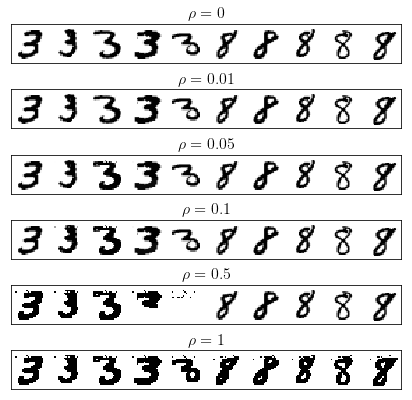

In [7]:
data = np.zeros([x_train.shape[0], x_train.shape[1], epsilons.size + 1])
for i in range(6):
    if i == 0:
        data[:,:,i] = x_train.toarray()
    else:
        # The solution alpha1 & alpha2 is eighter zero or one
        q = q1[:, :, i-1] * alpha1[:, i-1][:, None]
        q = q + q2[:, :, i-1] * alpha2[:, i-1][:, None]
        data[:,:,i] = x_train.toarray() + q
fig, arr_ax = gen_image(data, np.insert(epsilons, 0, 0))
fig.savefig(DIR_FIGURES + 'worst_inf.eps', format='eps', dpi=1000)
fig.set_facecolor('white')

In [6]:
q_p = np.zeros([x_train.shape[0], x_train.shape[1], 2, epsilons.size])
q_n = np.zeros([x_train.shape[0], x_train.shape[1], 2, epsilons.size])
alpha_p = np.zeros([x_train.shape[0], 2, epsilons.size])
alpha_n = np.zeros([x_train.shape[0], 2, epsilons.size])
for index, epsilon in enumerate(epsilons):
    tmp1, tmp2, tmp3, tmp4 = dro_model.worst_case_distribution(
        training_data, w_opt, epsilon, 0, C, d)
    alpha_p[:, :, index] = tmp1
    q_p[:, :, :, index] = tmp2
    alpha_n[:, :, index] = tmp3
    q_n[:, :, :, index] = tmp4

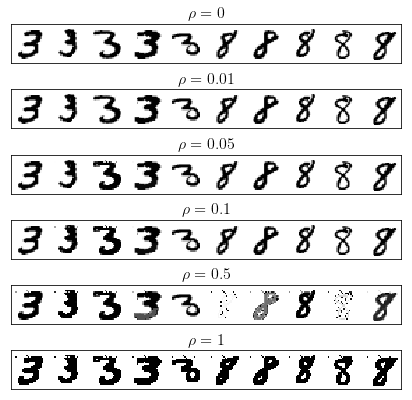

In [9]:
data2 = np.zeros([x_train.shape[0], x_train.shape[1], epsilons.size + 1])
for i in range(6):
    if i == 0:
        data2[:,:,i] = x_train.toarray()
    else:
        # The solution alpha_p & alpha_n is eighter zero or one
        q = q_p[:, :, 0, i-1] * alpha_p[:, 0, i-1][:, None]
        q += q_p[:, :, 1, i-1] * alpha_p[:, 1, i-1][:, None]
        q += q_n[:, :, 0, i-1] * alpha_n[:, 0, i-1][:, None]
        q += q_n[:, :, 1, i-1] * alpha_n[:, 1, i-1][:, None]
        data2[:,:,i] = x_train.toarray() + q
fig2, arr_ax2 = gen_image(data2, np.insert(epsilons, 0, 0))
fig2.savefig(DIR_FIGURES + 'worst_0.eps', format='eps', dpi=1000)
fig2.set_facecolor('white')

In [5]:
# np.save(DIR_CACHE + 'alpha_p.npy', alpha_p)
# np.save(DIR_CACHE + 'alpha_n.npy', alpha_n)
# np.save(DIR_CACHE + 'q_p.npy', q_p)
# np.save(DIR_CACHE + 'q_n.npy', q_n)
# np.save(DIR_CACHE + 'q1.npy', q1)
# np.save(DIR_CACHE + 'q2.npy', q2)
# np.save(DIR_CACHE + 'alpha1.npy', alpha1)
# np.save(DIR_CACHE + 'alpha2.npy', alpha2)
alpha_p = np.load(DIR_CACHE + 'alpha_p.npy')
alpha_n = np.load(DIR_CACHE + 'alpha_n.npy')
q_p = np.load(DIR_CACHE + 'q_p.npy')
q_n = np.load(DIR_CACHE + 'q_n.npy')
q1 = np.load(DIR_CACHE + 'q1.npy')
q2 = np.load(DIR_CACHE + 'q2.npy')
alpha1 = np.load(DIR_CACHE + 'alpha1.npy')
alpha2 = np.load(DIR_CACHE + 'alpha2.npy')